In [1]:
import matplotlib.pyplot as plt
from numpy import genfromtxt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.ticker as mticker
import os
import pandas as pd
import itertools

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


headers = ["event_id", "track_id", "type", "x", "y", "z", "delta_E", "process"]


def proc_file(energy):
    filepath = os.path.join(os.getcwd(), f"spectrum/{energy}/proc.txt")
    with open(f'spectrum/{energy}/log.txt', 'r') as f:
        with open(filepath, 'w') as new_f:
            for i, line in enumerate(f):
                if "ProcName" in line:
                    new_f.write(line)
                    

# generate process name files
for i in os.listdir("spectrum/"):
    if os.path.isfile(f"spectrum/{i}/log.txt"):
        proc_file(i)

def proc_list(energy, my_data):
    proc = []
    with open(f'spectrum/{energy}/proc.txt', 'r') as f:
        for i, line in enumerate(f):
            #print(my_data[i], line.split()[3])
            proc.append(line.split()[3])
            #if i > 5:
            #    break
    return proc



In [2]:
## below is from prev scripts
def search_for_thing(column, search_param, my_data):
    electron_array = []
    for i in range(len(my_data.T[0])):
        if my_data.T[column][i] == search_param:
            electron_array.append(my_data[i])
    if len(electron_array) == 0:
        print("Couldn't find anything with", headers[column], f"= {search_param}")
    else: 
        print(headers[column], f" = {search_param}")
    return np.array(electron_array)


def find_electrons(my_data):
    arr = search_for_thing(2, 1, my_data) # look for electrons
    plt.scatter(arr.T[0], arr.T[1])
    plt.xlabel("event_id")
    plt.ylabel("track_id")
    
def integrate_over(event_num, track_num, data, param = 6):
    integrate = 0
    for i in range(len(data)):
        if data.T[0][i] == event_num and data.T[1][i] == track_num:
            integrate = integrate + data.T[param][i]
    return [event_num, track_num, integrate]

def integrate_over(event_num, track_num, data, param = 6, subtract = None):
    integrate = 0
    for i in range(len(data)):
        if data.T[0][i] == event_num and data.T[1][i] == track_num:
            if not subtract:
                integrate = integrate + data.T[param][i]
            if subtract:
                ## Need to check case where next track occurs but same event
                if data.T[0][i - 1] == event_num and data.T[1][i - 1] == track_num:
                    integrate = integrate + data.T[param][i] - data.T[param][i - 1]
                else:
                    integrate = integrate + 0
    return [event_num, track_num, integrate]
    
    
def track_length_and_energy(my_data, event_list = range(0, 20), track_list = range(0, 20)):
    # integrate energy data over track_id, event_id
    integrated_energy_by_event = []
    integrated_length_by_event_x = []
    integrated_length_by_event_y = []
    integrated_length_by_event_z = []
    for event in event_list:
        for track in track_list:
            integrated_energy_by_event.append(integrate_over(event, track, my_data))
            # get track lengths, `subtract = 1` shows delta track length
            integrated_length_by_event_x.append(integrate_over(event, track, my_data, param = 3, subtract = 1))
            integrated_length_by_event_y.append(integrate_over(event, track, my_data, param = 4, subtract = 1))
            integrated_length_by_event_z.append(integrate_over(event, track, my_data, param = 5, subtract = 1))

    ## convert to np arrays
    integrated_energy_by_event = np.array(integrated_energy_by_event)
    integrated_length_by_event_x = np.array(integrated_length_by_event_x)
    integrated_length_by_event_y = np.array(integrated_length_by_event_y)
    integrated_length_by_event_z = np.array(integrated_length_by_event_z)

    ## find magnitude of track lengths
    integrated_length_by_event = np.sqrt((integrated_length_by_event_x.T[2])**2 + (integrated_length_by_event_y.T[2])**2 + (integrated_length_by_event_z.T[2])**2)
    return integrated_length_by_event, integrated_energy_by_event




In [3]:
def search_for_proc(search_param, proc_list, my_data):
    proc_name = []
    for i in range(len(proc_list)):
        #print(proc_list[i])
        if proc_list[i] == search_param:
            proc_name.append(my_data[i])
            #print(proc_list[i])
    if len(proc_name) == 0:
        print("Couldn't find anything with", "process", f"= {search_param}")
    else: 
        print("ProcName", f"= {search_param}")
    return np.array(proc_name)

ProcName = eIoni


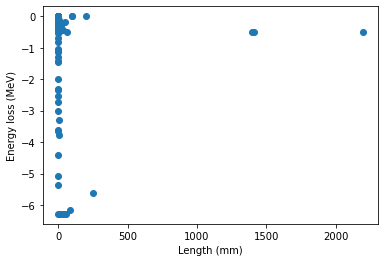

In [4]:
my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')

proc = proc_list(6283.8, my_data)

eioni = search_for_proc("eIoni", proc, my_data)

length, energy = track_length_and_energy(eioni)

plt.scatter(length, energy.T[2])
plt.xlabel("Length (mm)")
plt.ylabel("Energy loss (MeV)")
plt.show()

In [5]:
def subtractions_of_combinations(df):
    exclude = []
    # Extract all the combinations
    combinations = list(itertools.permutations(df.columns, 2)) 
    # Calculate the two possible subtractions for each combination
    new_df = pd.DataFrame()
    for a, b in combinations:
        diff = df[a] - df[b]
        if abs(diff["x"]) > 10.0 or abs(diff["y"]) > 10.0 or abs(diff["z"]) > 10.0:
            new_df[f'{a}-{b}'] = diff
        else:
            if f"{a}".split("__")[2] == f"{b}".split("__")[2]:
                continue
            else:
                exclude.append(f"{a}-{b}")
        diff = 0
    return new_df, exclude



def split_track_names(track_list):
    unique_tracks = np.empty((len(track_list), 2))
    for j, track in enumerate(track_list):
        #unique_tracks.append(j.split("-"))
        temp = track.split("-")
        for k, val in enumerate(temp):
            #print(val.split("__"))
            unique_tracks[j][k] = val.split("__")[2]

    #print(unique_tracks)
    unique_tracks = tuple(map(tuple, unique_tracks))

    final = []
    for i in unique_tracks:
        if i not in final and tuple(reversed(i)) not in final:
            final.append(i)
    return final

def first_and_last(my_data):
    reconstructed = []
    all_tracks = np.unique(my_data.T[1])
    #reconstructed.append(my_data[0])
    for i, track in enumerate(all_tracks):
        for j, val in enumerate(my_data):
            #if val[1] == track:
            #    reconstructed.append(val)
            if my_data[j - 1][1]:
                if val[1] == track and my_data[j - 1][1] != track:
                    reconstructed.append(val)
            #try:
                #if val[1] == track and my_data[j + 1][1] != track:
                #    reconstructed.append(val)
            #except IndexError:
            #    break
            
    return np.array(reconstructed)

def make_dataframe(eioni):
    track_event = []
    pos_array = []
    letterid = ["a", "b", "c"]
    for i, val in enumerate(eioni):
        ide = str(i) + "__" + str(int(val[0])) + "__" + str(int(val[1]))
        track_event.append(ide)
        pos_array.append(val[3:6])

    pos_array = np.array(pos_array).T


    #pos_array.T[0] = [0.0, 0.0, 1010.0]
    # creating a list of column names
    column_values = ['x', 'y', 'z']
    # creating the dataframe
    df = pd.DataFrame(data = pos_array, 
                      index = column_values, 
                      columns = track_event)
    return df

def blips_or_blobs(newdf, exclude):
    track_list = []
    for i in newdf.keys():
        track_list.append(i)

    track_list = np.unique(split_track_names(track_list))
    exclude = np.unique(split_track_names(exclude))

    new_track_list = []
    
    # find blips
    for i in track_list:
        if i not in exclude:
            new_track_list.append(i)

    # return blips, blobs
    return new_track_list, exclude

def blips_blobs_tracks(proc_string, proc, my_data, event_num):
    eioni = search_for_proc(proc_string, proc, my_data)
    eioni = search_for_thing(0, event_num, eioni)

    eioni = first_and_last(eioni)
    df = make_dataframe(eioni)
    newdf, exclude = subtractions_of_combinations(df)

    blips, blobs = blips_or_blobs(newdf, exclude)

    return blips, blobs


In [6]:
my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')
proc = proc_list(6283.8, my_data)


eioni = search_for_proc("eIoni", proc, my_data)
eioni = search_for_thing(0, 0, eioni)


test = first_and_last(eioni)


ProcName = eIoni
event_id  = 0


In [7]:
my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')
proc = proc_list(6283.8, my_data)

#my_data = search_for_proc("eIoni", proc, my_data)

for event_num in range(0, 19):
    try:
        blips, blobs = blips_blobs_tracks("eIoni", proc, my_data, event_num)
        print("Blips: ", blips, "Blobs: ", blobs, "Event: ", event_num)
    except ValueError:
        continue
    
ax = plt.figure().add_subplot(projection='3d')

my_data = search_for_thing(0, event_num, my_data)


for i in blips:
    track2 = search_for_thing(1, i, my_data)
    ax.scatter(track2.T[3], track2.T[4], track2.T[5], label = f"track {i}")
    

ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel("z (mm)")
ax.legend()
ax.set_title("Electron tracks from event 0")
plt.show()


ProcName = eIoni
event_id  = 0
Blips:  [4.0, 8.0] Blobs:  [ 2.  3.  5.  6.  7.  9. 10. 11. 12. 13.] Event:  0
ProcName = eIoni
event_id  = 1
Blips:  [1.0] Blobs:  [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 15. 16. 17. 18. 20. 21. 22.] Event:  1
ProcName = eIoni
event_id  = 2
Blips:  [1.0, 4.0] Blobs:  [2. 3.] Event:  2
ProcName = eIoni
event_id  = 3
ProcName = eIoni
event_id  = 4
Blips:  [1.0, 3.0, 5.0, 6.0] Blobs:  [ 2.  8.  9. 10.] Event:  4
ProcName = eIoni
event_id  = 5
Blips:  [1.0, 2.0, 3.0, 7.0] Blobs:  [] Event:  5
ProcName = eIoni
event_id  = 6
ProcName = eIoni
event_id  = 7
Blips:  [16.0] Blobs:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18. 19.] Event:  7
ProcName = eIoni
event_id  = 8
Blips:  [1.0, 6.0] Blobs:  [ 2.  3.  4.  5.  9. 12.] Event:  8
ProcName = eIoni
event_id  = 9
Blips:  [1.0, 5.0, 10.0] Blobs:  [ 2.  3.  4.  6.  7.  8. 11. 12. 13. 14. 15. 16.] Event:  9
ProcName = eIoni
event_id  = 10
ProcName = eIoni
event_id  = 11
Blips:  [1.0] Blob

IndexError: index 1 is out of bounds for axis 0 with size 0

event_id  = 3
[1.]
track_id  = 1.0


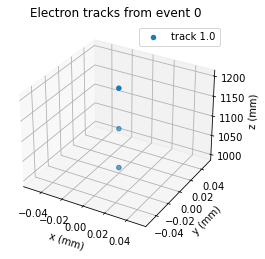

In [8]:

my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')
proc = proc_list(6283.8, my_data)
my_data = search_for_thing(0, 3, my_data)

tracks = np.unique(my_data.T[1])
print(tracks)
ax = plt.figure().add_subplot(projection='3d')
for i in tracks:
    track2 = search_for_thing(1, i, my_data)
    ax.scatter(track2.T[3], track2.T[4], track2.T[5], label = f"track {i}")
    
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel("z (mm)")
ax.legend()
ax.set_title("Electron tracks from event 0")
plt.show()


In [9]:
my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')
proc = proc_list(6283.8, my_data)

for i, val in enumerate(my_data):
    if val[0] == 1.0:
        print(val, proc[i])
all_ion = search_for_proc("eIoni", proc, my_data)

for i in all_ion:
    if i[0] == 3.0:
        print(i)
#for i, val in enumerate(my_data):
#    print(val, proc[i])

[   1.    1.    0.    0.    0. 1000.    0.    0.] eIoni
[   1.    1.    0.    0.    0. 1000.    0.    0.] eIoni
[   1.    1.    0.    0.    0. 1000.    0.    0.] eIoni
[ 1.00000e+00  1.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
  1.01678e+03 -6.28380e+00  0.00000e+00] eIoni
[ 1.00000e+00  4.00000e+00  2.00000e+00  2.83889e-07  1.23644e-07
  1.01678e+03 -1.52946e-06  0.00000e+00] eIoni
[1.00000e+00 4.00000e+00 2.00000e+00 2.83889e-07 1.23644e-07 1.01678e+03
 0.00000e+00 0.00000e+00] eIoni
[ 1.00000e+00  3.00000e+00  2.00000e+00 -9.11903e-04 -2.52247e-03
  1.01691e+03 -2.41960e-01  0.00000e+00] eIoni
[ 1.00000e+00  3.00000e+00  2.00000e+00 -2.90261e-02 -4.03346e-02
  1.01752e+03 -6.02582e-01  0.00000e+00] eIoni
[ 1.00000e+00  3.00000e+00  2.00000e+00  3.37831e-01  3.04898e-01
  1.01758e+03 -6.30758e-01  0.00000e+00] eIoni
[ 1.00000e+00  3.00000e+00  2.00000e+00  6.65265e-01  5.07837e-01
  1.01748e+03 -3.89416e-01  0.00000e+00] eIoni
[ 1.00000e+00  3.00000e+00  2.00000e+00  9.32777e

In [10]:
import sys
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

ProcName = eIoni
event_id  = 0
0.2560401
0.00653503
ProcName = eIoni
event_id  = 1
Not long enough
ProcName = eIoni
event_id  = 2
6.283804000000001
0.20552694
ProcName = eIoni
event_id  = 3
ProcName = eIoni
event_id  = 4
6.2838006
0.16940023
0.024740641
0.16999644
ProcName = eIoni
event_id  = 5
5.61657
5.156133809999998
0.46028220000000003
0.1306676
ProcName = eIoni
event_id  = 6
ProcName = eIoni
event_id  = 7
Not long enough
ProcName = eIoni
event_id  = 8
6.2838085999999995
0.16297129999999999
ProcName = eIoni
event_id  = 9
6.2838
0.510999
0.023849606
ProcName = eIoni
event_id  = 10
ProcName = eIoni
event_id  = 11
Not long enough
ProcName = eIoni
event_id  = 12
6.2838
0.5109985
0.12980201
ProcName = eIoni
event_id  = 13
0.5109983
0.1834978
0.052634730000000005
0.1297796
ProcName = eIoni
event_id  = 14
Not long enough
ProcName = eIoni
event_id  = 15
6.283795700000001
5.3870483999999985
ProcName = eIoni
event_id  = 16
6.283796
0.17960715
ProcName = eIoni
event_id  = 17
Not long enough
P

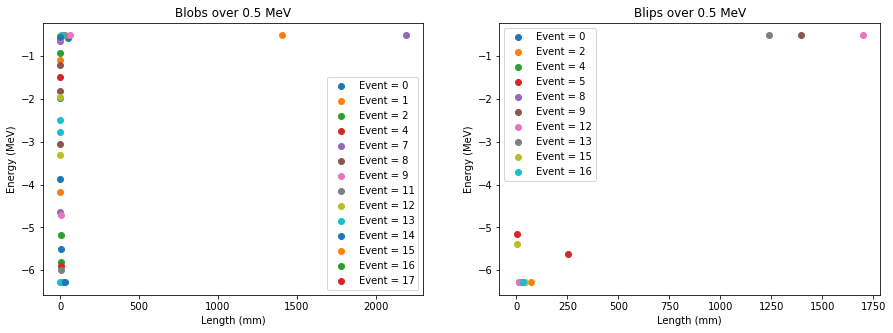

In [55]:
def number_vs_energy(ax1, ax2):
    
    my_data = genfromtxt(f'spectrum/6283.8/run_nt_Hits_t0.csv', delimiter=',')
    proc = proc_list(6283.8, my_data)

    #my_data = search_for_proc("eIoni", proc, my_data)

    for event_num in range(0, 19):
        #blockPrint()
        try:
            blips, blobs = blips_blobs_tracks("eIoni", proc, my_data, event_num)
            
            if len(blobs) > 1:
                blob_length, blob_energy = track_length_and_energy(my_data, event_list = [event_num], track_list = blobs)
                blobs_half_mev_length = []
                blobs_half_mev_energy = []
                for i, val in enumerate(blob_energy):
                    if abs(val[2]) > 0.5:
                        blobs_half_mev_energy.append(val[2])
                        blobs_half_mev_length.append(blob_length[i])
                ax1.scatter(blobs_half_mev_length, blobs_half_mev_energy, label = f"Event = {event_num}")
                
            
            if len(blips) > 1:
                blip_length, blip_energy = track_length_and_energy(my_data, event_list = [event_num], track_list = blips)
                blips_half_mev_length = blip_length
                blips_half_mev_energy = blip_energy.T[2]
                blips_half_mev_length = []
                blips_half_mev_energy = [] 
                for i, val in enumerate(blip_energy):
                    print(abs(val[2]))
                    if abs(val[2]) > 0.5:
                        blips_half_mev_energy.append(val[2])
                        blips_half_mev_length.append(blip_length[i])
                ax2.scatter(blips_half_mev_length, blips_half_mev_energy, label = f"Event = {event_num}")
            else:
                print("Not long enough")
        except ValueError:
            continue
        except IndexError:
            break
        #except IndexError:
        #enablePrint()
        
        #    print(blobs)
        #    break
        #
            

fig, ax = plt.subplots(1, 2, figsize = (15, 5))
number_vs_energy(ax[0], ax[1])
ax[0].set_title("Blobs over 0.5 MeV")
ax[0].set_xlabel("Length (mm)")
ax[0].set_ylabel("Energy (MeV)")

ax[1].set_title("Blips over 0.5 MeV")
ax[1].set_xlabel("Length (mm)")
ax[1].set_ylabel("Energy (MeV)")

ax[0].legend()
ax[1].legend()
plt.show()

